### Imports

In [101]:
from pygooglenews import GoogleNews
import json
import pandas as pd
from pandas import *
from dateparser import parse as parse_date
from datetime import date, datetime, timedelta
import matplotlib.pyplot as plt
from utils_art import *
import utils
import hashlib
import os
import test
pd.set_option('expand_frame_repr', False)
topic_list_main = ["TOP","WORLD","NATION","BUSINESS","TECHNOLOGY","ENTERTAINMENT","SCIENCE","SPORTS","HEALTH"] #"CAAqJQgKIh9DQkFTRVFvSUwyMHZNR3QwTlRFU0JXVnVMVWRDS0FBUAE"

## Functions

In [102]:
def getHeadlindTopic(gn, search = True, topic_sel=1, date1 = '2015-01-01', date2 = '2016-01-01') :
    entries_list = []
    if search :
        headlines_raw = gn.search(topic_list_main[topic_sel],from_=date1,to_=date2)
    else :
        if topic_sel == 0:
            headlines_raw = gn.top_news()
        else :
            headlines_raw = gn.topic_headlines(topic_list_main[topic_sel])
    return headlines_raw["entries"]

def rawHeadListToListList(rawHeadList, category="n/a") :
    new_list_d = []
    list_list_output = []
    for entry in rawHeadList :
        new_list_d.append({key: entry[key] for key in ["title", "link", "published", "source"]})
    for entry in new_list_d :
        list_for_entry = []
        link_str_list = entry["source"]["href"].split(".")
        link_str_list[0] = link_str_list[0].replace("https://","").replace("http://","").replace("www","")
        if link_str_list[0] == "" :
            link_str_list = link_str_list[1:]
        published_date = parse_date(entry["published"]).date()
        pk = entry["link"].split("articles/")[1].replace("?oc=5","")
        hash_key = hashlib.shake_256(str(pk).encode()).hexdigest(20)
        
        list_for_entry.append(entry["title"]) # "title"
        list_for_entry.append(entry["link"]) # "link"
        list_for_entry.append(published_date) # "published"
        list_for_entry.append(entry["source"]["href"]) # "source_url"
        list_for_entry.append(entry["source"]["title"]) # "source_title"
        list_for_entry.append(category) # "category"
        list_for_entry.append(published_date.year) # "year"
        list_for_entry.append(str(published_date.strftime('%Y-%m'))) # "year_month"
        list_for_entry.append(pk) # "pk"
        list_for_entry.append(link_str_list[:-1]) # "url_list"
        list_for_entry.append(link_str_list[-1]) # "url_TLD"
        list_for_entry.append(hash_key) # "hash_key"
        
        list_list_output.append(list_for_entry)
        
    return list_list_output

def fillDFwithListList(df, ListList):
    for ent in ListList:
        df.loc[len(df)] = ent
    return df

def fullWorkflow(gn, df, search = True, topic_sel=1, date1 = '2015-01-01', date2 = '2016-01-01') :
    headlines_raw = getHeadlindTopic(gn, search, topic_sel, date1, date2)
    headlinesMat = rawHeadListToListList(headlines_raw, topic_list_main[topic_sel])
    df_out = fillDFwithListList(df, headlinesMat)
    return df_out, len(headlinesMat)

def getStandardDf(col_list=[]):
    return pd.DataFrame([], columns = col_list) 

def addToDFHeadlinesParamList(gn, topic_list=[0], date_list_1 = ['2015-01-01'], date_list_2 = ['2016-01-01'], display=True,save=True,iteration=-1):
    if iteration != -1:
        iteration_str = str(iteration)
    else :
        iteration_str = ""
    if display :
        expected_article = logStartWorkflow(topic_list,date_list_1,date_list_2)
    df_out = getStandardDf(select_fields)
    date_list_len = len(date_list_1)
    for j in range(date_list_len) :
        ar_count = 0
        for i in topic_list :
            df_out, ar_num = fullWorkflow(gn, df_out, False , i, date_list_1[j], date_list_2[j])
            ar_count = ar_count + ar_num
        if display :
            log("     - Sample num "+str(j+1)+" done ("+str(ar_count)+" articles found)")
    if save :
        if display :
            log(" - Saving result table : '"+str(main_path)+str(filename)+"_"+iteration_str+".csv'")
        saveDFcsv(df_out, main_path, filename+"_"+iteration_str,False)
    if display :
        logEndWorkflow(df_out.shape[0], expected_article)
    return df_out

def loop_scraping(number_topics=8, startDate='2010-01-01', endDate='2024-01-01', sampling_1=14, sampling_2=6, display=True,save_steps=True,save_final=True):
    total_article_count = 0
    topic_list = list(range(0,number_topics))
    date_list_start, date_list_end = splitDateList(generateDateList(startDate=startDate, endDate=endDate,sampling=sampling_1))
    df_out = getStandardDf(select_fields)
    if display :
        expected_article = logStartWorkflow(topic_list,date_list_start,date_list_end,True)
    for i in range(len(date_list_start)) :
        date_list_entry_start, date_list_entry_end = splitDateList(generateDateList(startDate=date_list_start[i], endDate=date_list_end[i],sampling=sampling_2))
        df = addToDFHeadlinesParamList(gn, topic_list, date_list_entry_start, date_list_entry_end,display,save_steps,i)
        total_article_count = total_article_count + df.shape[0]
        df_out = pd.concat([df_out, df], ignore_index=True)
    logEndWorkflow(total_article_count, expected_article*sampling_2,True)
    if save_final :
        saveDFcsv(df_out, main_path, filename+"_final",False)
    return df_out

def loadFromFolder(folder_path="",force_schema=[],save=False, unicity_key="hash_key",cast_date_col="published"):
    import os
    if folder_path == "" :
        folder_path = main_path
    # df_out = getStandardDf(select_fields)
    root_path = Path(folder_path)
    file_list = os.listdir(root_path)
    first_flag = True
    for filename_entry in file_list:
        if ".csv" in filename_entry :
            df = openDFcsv(folder_path,filename_entry.replace(".csv",""))
            if first_flag :
                first_flag = False
                df_out = df
            else :
                df_out = pd.concat([df_out, df], ignore_index=True)
    if "Unnamed: 0" in list(df_out.columns) :
        df_out = df_out.rename(columns={"Unnamed: 0":"index"})
    if force_schema!=[] :
        df_out = df_out[force_schema]
    if unicity_key != "" and unicity_key in list(df_out.columns) :
        df_out = df_out.drop_duplicates(subset=['hash_key'])
    if cast_date_col != "" and cast_date_col in list(df_out.columns) :
        df_out[cast_date_col+"_date_type"] = pd.to_datetime(df_out[cast_date_col])
    if save :
        saveDFcsv(df_out, folder_path, filename+"_all_aggregated")
    return df_out

def generateDateList(startDate='2015-01-01', endDate='2020-01-01', sampling=10, includeEnd=True):
    date_list = []
    start = parse_date(startDate).date()
    end = parse_date(endDate).date()
    current_date = start
    interval_in_days = int((end-start).days/sampling)
    for i in range(sampling+int(includeEnd)) :
        date_list.append(current_date.strftime('%Y-%m-%d'))
        current_date = current_date + timedelta(days = interval_in_days)
    return date_list

def splitDateList(date_list) :
    date_list_len = len(date_list)
    date_list1 = date_list[0:date_list_len-1]
    date_list2 = date_list[1:date_list_len]
    return date_list1, date_list2

def log(string, print_str=True, log_str=True):
    if print_str :
        print(string)
    if log_str :
        log_file.write(string)
        log_file.write("\n")

def logStartWorkflow(topic_list,date_list_1,date_list_2,loop_module=False):
    min_date = parse_date(date_list_1[0])
    max_date = parse_date(date_list_2[-1])
    total_period = (max_date-min_date).days
    sampling_period = total_period/len(date_list_1)
    expected_article = 100*len(topic_list)*len(date_list_1)
    articles_per_day = expected_article/total_period
    if loop_module :
        log("   -===-   -===-   Loop Scrapping module start   -===-   -===-   ")
    else :
        log("   -===-   Scrapping module start   -===-   ")
    log(" - List of topics : '"+str(topic_list)+"'  ("+str(len(topic_list))+")")
    log(" - From '"+str(min_date)+"'' to '"+str(max_date)+"' ("+str(total_period)+" days)")
    log(" - Sampling this numebr of periods : '"+str(len(date_list_1))+"'  ("+str(sampling_period)+" days)")
    log(" - Expected articles found : '"+str(expected_article)+"''  ("+str(articles_per_day)+"/day)")
    if loop_module :
        log("")
        log("")
    return expected_article
    
def logEndWorkflow(found_articles, expected_article,loop_module=False) :
    if loop_module :
        log("")
        log("")
    log(" - Total of '"+str(found_articles)+"' articles found ("+str(round(100*found_articles/expected_article,2))+"% of expected) !")
    if loop_module :
        log("   -===-   -===-   Loop Scrapping module end   -===-   -===-   ")
    else :
        log("   -===-   Scrapping module end   -===-   ")
        log("")

def displayStats(df) :
    print("\n   ------   Raw dataframe   ------   \n")
    print("Shape : ",df.shape)
    print("Column type : ",df.dtypes)
    display(df)
    print("\n   ------   Most common sources   ------   \n")
    print(df['source_title'].value_counts())
    print("\n   ------   Most common topics   ------   \n")
    print(df['category'].value_counts())
    print("\n   ------   Most common dates   ------   \n")
    print(df['published'].value_counts())

def plotDFstatisticsQuerry(df, source_limit=50,onlyYear=False) :
    if onlyYear :
        time_field = "year"
    else :
        time_field = "year_month"
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7, 15))

    df_category = df['category'].value_counts().to_frame("count").sort_values(by=['count'],ascending=True)
    
    df_source = df['source_title'].value_counts().to_frame("count").sort_values(by=['count'],ascending=True)
    source_limiy_count = int(df_source.iloc[[int(-source_limit)]]["count"].tolist()[0])
    df_source = df_source[df_source['count'].between(source_limiy_count, 1000000)]

    df_date_year_month = df[time_field].value_counts().to_frame("count").sort_values(by=[time_field],ascending=True)
    axes[1].tick_params(labelcolor='black', labelright=True, labelleft=False)
    axes[1].invert_yaxis()

    plot = df_source.plot.barh(y='count',use_index=True,ax=axes[0], legend=False, ylabel="", fontsize= 8, title="Sources") #, figsize=(5, 5)
    plot = df_date_year_month.plot.barh(y='count',use_index=True,ax=axes[1], legend=False, ylabel="", fontsize= 8, title="Volume month/year") #, figsize=(5, 5)
    plot = df_category.plot.pie(y='count',use_index=True, legend=False, ylabel="", title="Distribution of categories") #, figsize=(5, 5)
    
    
    
def joinQuerryAndParse(save=True,remove_invalid=True,display=True) :
    # rename_dict = {"title_q":"title_quer","title_p":"title_par","published_q":"published","year_q":"year","year_month_q":"year_month","source_url_q":"source_url","url_list_q":"url_list","url_TLD_q":"url_TLD","source_title_q":"source_title","category_q":"category","authors":"authors","keywords_list":"keywords_list","text_len_p":"text_len","tb.sentences":"tb.sentences","tb.noun_phrases":"tb.noun_phrases","tb.words":"tb.words","tb.polarity":"tb.polarity","tb.subjectivity":"tb.subjectivity","tb.p_pos":"tb.p_pos","tb.p_neg":"tb.p_neg","vs.neg":"vs.neg","vs.neu":"vs.neu","vs.pos":"vs.pos","vs.compound":"vs.compound","valid":"valid","link_q":"link","pk_q":"pk",}
    rename_dict = {"title_q":"title_quer","title_p":"title_par","published_q":"published","year_q":"year","year_month_q":"year_month","source_url_q":"source_url","url_list_q":"url_list","url_TLD_q":"url_TLD","source_title_q":"source_title","category_q":"category","authors":"authors","keywords_list":"keywords_list","text_len_p":"text_len","tb.sentences":"sentences","tb.noun_phrases":"noun_phrases","tb.words":"words","tb.polarity":"polarity","tb.subjectivity":"subjectivity","tb.p_pos":"pos2","tb.p_neg":"neg2","vs.neg":"neg1","vs.neu":"neu1","vs.pos":"pos1","vs.compound":"compound","valid":"valid","link_q":"link","pk_q":"pk",}
    
    df_q = loadFromFolder(main_path,save=False)
    df_q = df_q.set_index('hash_key')
    df_q_len = df_q.shape[0]
    if display :
        print("QUERRY dataset loaded from ",main_path)
        print("QUERRY dataset has entry length of :",df_q_len,"\n")

    df_p = loadFromFolder(path_parse_stat,save=False)
    df_p = df_p.set_index('hash_key')
    df_p_len = df_p.shape[0]
    if display :
        print("PARSSING dataset loaded from ",path_parse_stat)
        print("PARSSING dataset has entry length of :",df_p_len," ("+str(round(100*df_p_len/df_q_len))+"% of querry data)\n")
    
    df = df_q.join(df_p, how="inner",on='hash_key', lsuffix='_q', rsuffix='_p')
    df = df.rename(columns=rename_dict)
    # df = df[list(rename_dict.values())]
    join_df_len = df.shape[0]
    if display :
        print("JOINED dataset has entry length of :",join_df_len," ("+str(round(100*join_df_len/df_p_len))+"% of parssing data)")
    if remove_invalid :
        df = df.loc[(df['valid'] == True)]
        join_df_valid_len = df.shape[0]
        if display :
            print("JOINED dataset VALID entries :",join_df_valid_len," ("+str(round(100*join_df_valid_len/join_df_len))+"% of joined data)")
            print("JOINED dataset INVALID entries :",join_df_len-join_df_valid_len," ("+str(round(100*(join_df_len-join_df_valid_len)/join_df_len))+"% of joined data)\n")
        join_df_len = join_df_valid_len
    if display :
        print("TOTAL yield : from",df_q_len," to ",join_df_len,"("+str(round(100*join_df_len/df_q_len))+"% yeald)\n")
    if save :
        saveDFcsv(df,path_union_stat,filename_union_stat)
        if display :
            print("JOINED dataset saved here :",path_union_stat+filename_union_stat+".csv")
    return df

def calculateStatsLength(df,groupping,display_df=True):
    rename_dict = {"text_len":"char_n","sentences":"sentence_n","noun_phrases":"noun_n","words":"words_n"}
    df = df.rename(columns=rename_dict)
    df_group = df[[groupping,"char_n","sentence_n","noun_n","words_n"]].groupby(groupping).sum(["char_n","sentence_n","noun_n","words_n"])
    df_count = df[groupping].value_counts().to_frame("count")#
    df_main = df_group.join(df_count, how="inner",on=groupping).sort_values(by=['count'],ascending=True)
    df_main[["char_per_count","sentence_per_count","noun_per_count","word_per_count"]] = df_main[["char_n","sentence_n","noun_n","words_n"]].div(df_main['count'], axis=0).astype(float)
    df_main[["char_per_sentence","noun_per_sentence","word_per_sentence"]] = df_main[["char_n","noun_n","words_n"]].div(df_main["sentence_n"], axis=0).astype(float)
    df_main[["char_per_word"]] = df_main[["char_n"]].div(df_main["words_n"], axis=0).astype(float)
    df_main = df_main.sort_values(by=["count"],ascending=True)
    if display_df :
        print("Dataframe Statistics Length Column :'"+groupping+"'")
        display(df_main)
    return df_main

def calculateStatsNLP(df,groupping,display_df=True,display_stats=False,out_raw=False):
    rename_dict = {"polarity":"Polarity","subjectivity":"Subjectivity","pos1":"Positivity","neu1":"Neutrality","neg1":"Negativity","pos2":"Positivity2","neg2":"Negativity2","compound":"Compound"}
    df = df.rename(columns=rename_dict)
    column_list = list(rename_dict.values())
    column_list_ajusted = []
    for field_count in column_list :
        if display_stats :
            print(field_count," ",getStatsFromCol(df,field_count))
        df[field_count+"_aj"] = (df[field_count]-getStatsFromCol(df,field_count)[0])/getStatsFromCol(df,field_count)[2]
        column_list_ajusted.append(field_count+"_aj")
    if out_raw :
        df_main = df
    else :
        column_list = column_list + column_list_ajusted
        df_group = df[[groupping]+column_list].groupby(groupping).sum(column_list)
        df_count = df[groupping].value_counts().to_frame("count")#
        df_main = df_group.join(df_count, how="inner",on=groupping).sort_values(by=['count'],ascending=True)
        list_field_count = []
        for field in column_list :
            list_field_count.append(field+"_per_count")
        df_main[list_field_count] = df_main[column_list].div(df_main['count'], axis=0).astype(float)
        df_main = df_main.sort_values(by=["count"],ascending=True)
    if display_df :
        print("Dataframe Statistics NLP Column :'"+groupping+"'")
        display(df_main)
    return df_main

def getStatsFromCol(df, column) :
    min_val = df[column].min()
    max_val = df[column].max()
    return min_val,max_val,max_val-min_val

def calculateStatsColList(df, column_list=[],stat_type="len",display_df=True,display_stats=False,out_raw=False):# ,stat_type="nlp"
    df_list_out = []
    for col in column_list :
        if stat_type=="len":
            df_app = calculateStatsLength(df,col,display)
            df_list_out.append(df_app)
        if stat_type=="nlp":
            df_app = calculateStatsNLP(df,col,display,display_stats,out_raw)
            df_list_out.append(df_app)
    return df_list_out

def joinArticleStatsAndLLM(df_art,save=True,display=True) :
    df_llm = loadFromFolder(llm_result,save=False) # ,"","".set_index('hash_key')
    df_llm = df_llm.set_index('hash_key')
    df = df_art.join(df_llm, how="inner",on='hash_key',lsuffix='', rsuffix='_llm')#, 
    # df = df[union_fields2]
    join2_df_len = df.shape[0]
    df_art_len = df_art.shape[0]
    if display :
        print("JOINED2 dataset has entry length of :",join2_df_len," ("+str(round(100*join2_df_len/df_art_len))+"% of JOINED1 data)")
    if save :
        saveDFcsv(df,llm_join_out,llm_join_out_filename)
    return df

def selectOnDf(df, date_start="2015-01-01", date_end="2017-06-01", categroy_list=[], source_list=[]) :
    df = df.loc[(df['published'] >= date_start) & (df['published'] < date_end)]
    if categroy_list != [] :
        df = df[df['category'].isin(categroy_list)]
    if source_list != [] :
        df = df[df['source_title'].isin(source_list)]
    return df



def displayDF(df,col_name) :
    print(df[col_name].value_counts().describe([.05, .25, .5, .75, .95]))
    return df.shape[0], df[col_name].value_counts()

def getStandardDfInput(input_fields):
    return pd.DataFrame([], columns = input_fields) 

def filterQuerryDataset(df,thd_high=5000,thd_low=30, display_stats=True,display_end_stats=False) :
    ser_source = df['source_title'].value_counts()
    init_size = df.shape[0]
    init_uni_size = len(ser_source)
    if display_stats :
        print("START     - ",{"len":df.shape[0],"uni_len":len(ser_source),"average_uni_len":df.shape[0]/len(ser_source)})
    ser_source_high = ser_source[ser_source > thd_high]
    ser_source_low = ser_source[ser_source < thd_low]
    ser_source_med = ser_source[(ser_source > thd_low) & (ser_source < thd_high)]
    list_source_low = list(ser_source_low.keys())
    df = df[~df['source_title'].isin(list_source_low)]
    ser_source = df['source_title'].value_counts()

    print("DELETE LOW - ",{"len":df.shape[0],"uni_len":len(ser_source),"average_uni_len":df.shape[0]/len(ser_source)})
    
    ser_source_high = ser_source[ser_source > thd_high]
    list_source_high = list(ser_source_high.keys())
    start_df = getStandardDfInput(list(df.columns))
    for source_high in list_source_high :
        newdf = df.loc[(df['source_title'] == source_high)].sort_values(by=["hash_key"],ascending=False).head(thd_high)
        start_df = pd.concat([start_df,newdf]).reset_index(drop=True)
    df = df[~df['source_title'].isin(list_source_high)]
    df = pd.concat([df,start_df]).reset_index(drop=True)
    ser_source = df['source_title'].value_counts()
    end_size = df.shape[0]
    end_uni_size = len(ser_source)
    
    print("CAP HIGH    - ",{"len":df.shape[0],"uni_len":len(ser_source),"average_uni_len":df.shape[0]/len(ser_source)})
    print("len loss :",float(100*(init_size-end_size)/init_size),"%","     uni_len loss :",float(100*(init_uni_size-end_uni_size)/init_uni_size),"%")
    print("MAX :",max(df['source_title'].value_counts()),"  MIN :",min(df['source_title'].value_counts()))
    
    if display_end_stats :
        plotDFstatisticsQuerry(df,onlyYear=True)
    return df




## Variables

In [103]:
env = "arc/"
main_path = "C:/Users/User/OneDrive/Desktop/article/files_3/1_1_query_main/"+env
filename = "reduction_test"

path_parse_stat = "C:/Users/User/OneDrive/Desktop/article/files_3/1_2_scarp_main/"+env

path_union_stat = "C:/Users/User/OneDrive/Desktop/article/files_3/1_4_join_main/"+env
filename_union_stat = "join_main_test-filter"

llm_result = "C:/Users/User/OneDrive/Desktop/article/file_2/test_llm_output/new_embedding/"

llm_join_out = "C:/Users/User/OneDrive/Desktop/article/file_2/join_2_df/"
llm_join_out_filename = "article_stats_embedding"


# union_fields = ["hash_key","title_quer","title_par","published","year","year_month","source_url","url_list","url_TLD","source_title","category","authors","keywords_list","text_len","tb.sentences","tb.noun_phrases","tb.words","tb.polarity","tb.subjectivity","tb.p_pos","tb.p_neg","vs.neg","vs.neu","vs.pos","vs.compound","valid","link","pk"]
# union_fields2 = ["hash_key","title_quer","title_par","published","year","year_month","source_url","url_list","url_TLD","source_title","category","authors","keywords_list","text_len","sentences","noun_phrases","words","polarity","subjectivity","pos2","neg2","neg1","neu1","pos1","compound","i_model","i_dimensions","i_encoding_format","i_user","o_data","link","pk"]

select_fields = ["title","link", "published", "source_url", "source_title", "category", "year", "year_month","pk","url_list","url_TLD", "hash_key"] #,"id", "sub_articles", "source"
# select_fields_parse = ["url","pk","hash_key","title","authors","publish_date","keywords_list","text_len","valid","tb.sentences","tb.noun_phrases","tb.words","tb.polarity","tb.subjectivity","tb.p_pos","tb.p_neg","vs.neg","vs.neu","vs.pos","vs.compound"]
log_filename = "log"
language = "en"#"fr"#
country = "US"#"FR"#
gn = GoogleNews(lang = language, country = country)
log_file = open(main_path+log_filename+".txt", "a", encoding="utf-8")

# Main

START     -  {'len': 244838, 'uni_len': 9444, 'average_uni_len': 25.92524354087251}
DELETE LOW -  {'len': 197513, 'uni_len': 688, 'average_uni_len': 287.0828488372093}
CAP HIGH    -  {'len': 164642, 'uni_len': 688, 'average_uni_len': 239.30523255813952}
len loss : 32.754719447144645 %      uni_len loss : 92.7149512918255 %
MAX : 6500   MIN : 40


True

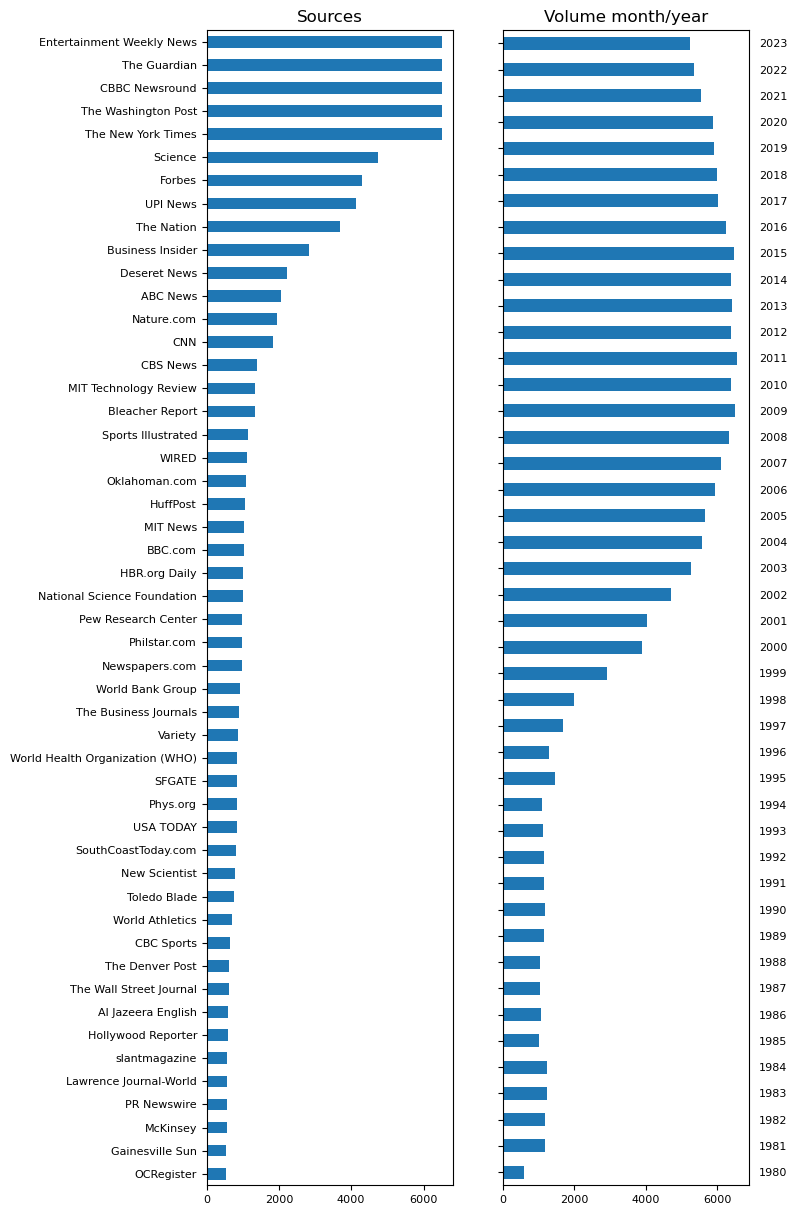

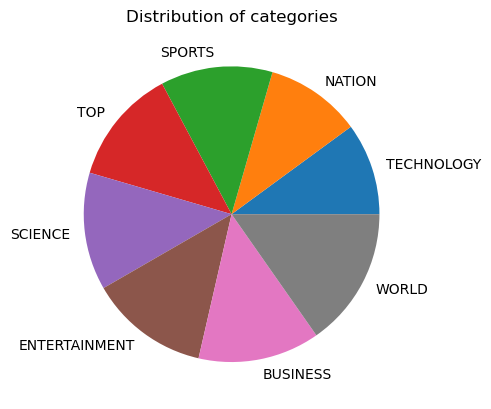

In [104]:
"""   Loading/Generating Querry Dataframe   """
#df = loadFromFolder(main_path,save=False)
# df = openDFcsv("C:/Users/User/OneDrive/Desktop/article/files_3/1_1_query_main/arc/","query_main_1980_to_2023")
# df = df.sort_values(by=["hash_key"],ascending=False).head(30000)

# df = loop_scraping(8,'1980-01-01','2024-01-01',44,12)
# df = loop_scraping(8,'1980-01-01','2024-01-01',10,10)
#df = loop_scraping(1,'2010-01-01','2024-01-01',1,1,save_steps=False,save_final=True)
# loop_scraping(number_topics=8,             #1-8
#               startDate='2010-01-01',
#               endDate='2024-01-01',
#               sampling_1=14,              # num year
#               sampling_2=6,               #in year
#               display=True,
#               save_steps=True,
#               save_final=True):

"""   Loading/Generating Parsed or Joined Dataframe   """

### Loading
# df = loadFromFolder(path_parse_stat,save=False)

### Generating
#df = joinQuerryAndParse()

### Joining
# df = joinArticleStatsAndLLM(df,save=False)

# display(df.head())

df = openDFcsv("C:/Users/User/OneDrive/Desktop/article/files_3/1_1_query_main/arc/","query_main_1980_to_2023")
df = filterQuerryDataset(df,thd_high=6500,thd_low=40, display_stats=True,display_end_stats=True)
saveDFcsv(df, "C:/Users/User/OneDrive/Desktop/article/files_3/1_1_query_main/arc/", "reduction_test")
# displayStats(df)


In [108]:
saveDFcsv(df, "C:/Users/User/OneDrive/Desktop/article/files_3/1_1_query_main/arc/", "reduction_test2")
displayStats(df)


   ------   Raw dataframe   ------   

Shape :  (10267, 12)
Column type :  title           object
link            object
published       object
source_url      object
source_title    object
category        object
year            object
year_month      object
pk              object
url_list        object
url_TLD         object
hash_key        object
dtype: object


,title,link,published,source_url,source_title,category,year,year_month,pk,url_list,url_TLD,hash_key
0,Appeals court puts controversial Texas immigra...,https://news.google.com/rss/articles/CBMiWGh0d...,2024-03-20,https://www.cnn.com,CNN,TOP,2024,2024-03,CBMiWGh0dHBzOi8vd3d3LmNubi5jb20vMjAyNC8wMy8xOS...,[cnn],com,b3f172099ed6fd2ea5e4f670c3b9e9fe8c602778
1,A fourth former Mississippi officer sentenced ...,https://news.google.com/rss/articles/CBMiYWh0d...,2024-03-20,https://www.cnn.com,CNN,TOP,2024,2024-03,CBMiYWh0dHBzOi8vd3d3LmNubi5jb20vMjAyNC8wMy8yMC...,[cnn],com,4b172193d26a75adb9d3e7afaea9ee83e9a2887e
2,New York AG pushes back on Trump's 'extraordin...,https://news.google.com/rss/articles/CBMiYWh0d...,2024-03-20,https://abcnews.go.com,ABC News,TOP,2024,2024-03,CBMiYWh0dHBzOi8vYWJjbmV3cy5nby5jb20vVVMvbmV3LX...,"[abcnews, go]",com,dbe2bec9b127554d556ea3fe46e0a9dca88dad7b
3,Leo Varadkar: I am no longer best man to be Ir...,https://news.google.com/rss/articles/CBMiLmh0d...,2024-03-20,https://www.bbc.com,BBC.com,TOP,2024,2024-03,CBMiLmh0dHBzOi8vd3d3LmJiYy5jb20vbmV3cy93b3JsZC...,[bbc],com,3e40fe2a85c05e5fcad1d6a9210c604af0a32478
4,Arkansas airport exec wounded in gunfight with...,https://news.google.com/rss/articles/CBMie2h0d...,2024-03-20,https://www.foxnews.com,Fox News,TOP,2024,2024-03,CBMie2h0dHBzOi8vd3d3LmZveG5ld3MuY29tL3VzL2Fya2...,[foxnews],com,2cadca495ab8f3bc084fc8a163351fe88b27d935
...,...,...,...,...,...,...,...,...,...,...,...,...
10262,Richard Hughes appointed as Liverpool sporting...,https://news.google.com/rss/articles/CBMiRGh0d...,2024-03-20,https://theathletic.com,The Athletic,SPORTS,2024,2024-03,CBMiRGh0dHBzOi8vdGhlYXRobGV0aWMuY29tLzUzMjI5MT...,[theathletic],com,3e1a878c78c566e53d7dafe0e707eb068bbc2962
10263,March Madness: How LeBron James helped revital...,https://news.google.com/rss/articles/CBMieGh0d...,2024-03-20,https://sports.yahoo.com,Yahoo Sports,SPORTS,2024,2024-03,CBMieGh0dHBzOi8vc3BvcnRzLnlhaG9vLmNvbS9tYXJjaC...,"[sports, yahoo]",com,b43663de10e4e064b24f219a69ce56a23c799de9
10264,"Oakland coach says Kentucky is the ""best match...",https://news.google.com/rss/articles/CBMieWh0d...,2024-03-20,https://www.aseaofblue.com,A Sea Of Blue,SPORTS,2024,2024-03,CBMieWh0dHBzOi8vd3d3LmFzZWFvZmJsdWUuY29tLzIwMj...,[aseaofblue],com,c413ee837146af49bb2bd8d4160169a4d6e1c957
10265,Even CBS announcers incensed by 'unwatchable' ...,https://news.google.com/rss/articles/CBMiZmh0d...,2024-03-20,https://nypost.com,New York Post,SPORTS,2024,2024-03,CBMiZmh0dHBzOi8vbnlwb3N0LmNvbS8yMDI0LzAzLzIwL3...,[nypost],com,1d4d12d87a231ba639baa9d4f27cb41686628fb7



   ------   Most common sources   ------   

source_title
CNN                    528
The New York Times     466
Fox News               360
BBC.com                341
The Washington Post    288
                      ... 
STAT                    24
A Sea Of Blue           24
Euronews                19
Page Six                19
The Moscow Times        19
Name: count, Length: 178, dtype: int64

   ------   Most common topics   ------   

category
SCIENCE          1680
SPORTS           1680
NATION           1656
WORLD            1387
BUSINESS         1032
ENTERTAINMENT     984
TECHNOLOGY        936
TOP               912
Name: count, dtype: int64

   ------   Most common dates   ------   

published
2024-03-20    8803
2024-03-19    1368
2024-03-18      96
Name: count, dtype: int64


In [109]:
df = loop_scraping(8,'2020-01-01','2024-01-01',2,12,save_steps=False,save_final=True)

   -===-   -===-   Loop Scrapping module start   -===-   -===-   
 - List of topics : '[0, 1, 2, 3, 4, 5, 6, 7]'  (8)
 - From '2020-01-01 00:00:00'' to '2023-12-31 00:00:00' (1460 days)
 - Sampling this numebr of periods : '2'  (730.0 days)
 - Expected articles found : '1600''  (1.095890410958904/day)


   -===-   Scrapping module start   -===-   
 - List of topics : '[0, 1, 2, 3, 4, 5, 6, 7]'  (8)
 - From '2020-01-01 00:00:00'' to '2021-12-21 00:00:00' (720 days)
 - Sampling this numebr of periods : '12'  (60.0 days)
 - Expected articles found : '9600''  (13.333333333333334/day)
     - Sample num 1 done (427 articles found)
     - Sample num 2 done (427 articles found)
     - Sample num 3 done (427 articles found)
     - Sample num 4 done (427 articles found)
     - Sample num 5 done (427 articles found)
     - Sample num 6 done (427 articles found)
     - Sample num 7 done (427 articles found)
     - Sample num 8 done (427 articles found)
     - Sample num 9 done (427 articles found)

In [110]:


# displayDF(df)

def displayDF(df,col_name) :
    print(df[col_name].value_counts().describe([.05, .25, .5, .75, .95]))
    return df.shape[0], df[col_name].value_counts()

def getStandardDfInput(input_fields):
    return pd.DataFrame([], columns = input_fields) 

def filterQuerryDataset(df,thd_high=5000,thd_low=30, display_stats=True) :
    ser_source = df['source_title'].value_counts()
    init_size = df.shape[0]
    init_uni_size = len(ser_source)
    if display_stats :
        print("START     - ",{"len":df.shape[0],"uni_len":len(ser_source),"average_uni_len":df.shape[0]/len(ser_source)})
    ser_source_high = ser_source[ser_source > thd_high]
    ser_source_low = ser_source[ser_source < thd_low]
    ser_source_med = ser_source[(ser_source > thd_low) & (ser_source < thd_high)]
    list_source_low = list(ser_source_low.keys())
    df = df[~df['source_title'].isin(list_source_low)]
    ser_source = df['source_title'].value_counts()

    print("DELETE LOW - ",{"len":df.shape[0],"uni_len":len(ser_source),"average_uni_len":df.shape[0]/len(ser_source)})
    
    ser_source_high = ser_source[ser_source > thd_high]
    list_source_high = list(ser_source_high.keys())
    start_df = getStandardDfInput(list(df.columns))
    for source_high in list_source_high :
        newdf = df.loc[(df['source_title'] == source_high)].sort_values(by=["hash_key"],ascending=False).head(thd_high)
        start_df = pd.concat([start_df,newdf]).reset_index(drop=True)
    df = df[~df['source_title'].isin(list_source_high)]
    df = pd.concat([df,start_df]).reset_index(drop=True)
    ser_source = df['source_title'].value_counts()
    end_size = df.shape[0]
    end_uni_size = len(ser_source)
    
    print("CAP HIGH    - ",{"len":df.shape[0],"uni_len":len(ser_source),"average_uni_len":df.shape[0]/len(ser_source)})
    print("len loss :",float(100*(init_size-end_size)/init_size),"%","     uni_len loss :",float(100*(init_uni_size-end_uni_size)/init_uni_size),"%")
    print("MAX :",max(df['source_title'].value_counts()),"  MIN :",min(df['source_title'].value_counts()))
    
    return df





### Modules

In [ ]:
#M1
df = loadFromFolder(path_union_stat) #
col_list = ["category","source_title","year_month","url_TLD","year"]
df_list = calculateStatsColList(df,col_list,"len",display_df=True)
df_list = calculateStatsColList(df,col_list,"nlp",display_df=True,display_stats=False) #,out_raw=False

#M2
df_pol = df[["subjectivity"]].round(2).value_counts().to_frame("count").sort_values(by=['subjectivity'],ascending=True)
df_pol.plot.barh(y='count',use_index=True, rot=0, figsize=(7, 30), title="Words Cnt") # , logx=True

#M3
source_list = ["The New York Times","The Nation","Business Insider","Business Insider"]
out_df = selectOnDf(df,source_list=source_list)
display(out_df)

#M4
plotDFstatisticsQuerry(df)

#M5
displayStats(df)
#saveDFcsv(out_df, "C:/Users/User/OneDrive/Desktop/article/file_2/.bin/", "viz_test3")

# ---- Bin ----

In [ ]:
df_out = fullWorkflow(gn, df, topic_sel=1)
df_out = fullWorkflow(gn, df_out, topic_sel=2)
df_out = fullWorkflow(gn, df_out, topic_sel=3)
df_out = fullWorkflow(gn, df_out, topic_sel=0)
display(df_out)
test1 = getHeadlindTopic(gn, True, 1, '2015-01-01', '2016-01-01')
print(len(test1))
print(type(test1))
test2 = rawHeadListToListList(test1)
print(len(test2))
print(type(test2))
test3 = fillDFwithListList(df, test2)
display(test3)

from pygooglenews import GoogleNews
gn = GoogleNews(lang = 'fr', country = 'FR')
top = gn.geo_headlines('France')
print(top["entries"][0]["title"])

df = pd.DataFrame([], columns = ['Name' , 'Age', 'City' , 'Country']) 

from pygooglenews import GoogleNews
gn = GoogleNews(lang = 'en', country = 'US')
top = gn.search("HEALTH",from_='2020-01-01',to_='2020-01-02')
#top = gn.search("HEALTH")
print(len(top["entries"]))

from dateparser import parse as parse_date
validate = parse_date("2015")
print(str(validate.strftime('%Y-%m-%d')))

df_out2 = df_out[['source_title']].groupby('source_title').sum()
display(df_out2)

test_pie = df_out['category'].value_counts().to_frame("test_pie")
display(test_pie)
plot = test_pie.plot.barh(y='test_pie',use_index=True, figsize=(5, 5), legend=False)
test_pie = df_out['source_title'].value_counts().to_frame("test_pie")
output = test_pie[test_pie['test_pie'].between(10, 1000)]
plot = output.plot.barh(y='test_pie',use_index=True, figsize=(5, 5), legend=False)

# df_date = pd.DataFrame([], columns = ['date' , 'year', 'month', 'count']) 
df_date = df_out['published'].value_counts()
# df_date.loc[:, ('date')] = pd.DatetimeIndex(df_out.loc[:, ('published')])
# df_date.loc[:, ('year')] = pd.DatetimeIndex(df_out.loc[:, ('published')]).year
# df_date.loc[:, ('month')] = pd.DatetimeIndex(df_out.loc[:, ('published')]).month
display(df_date)
print(type(df_date))
test_df = df_date.to_frame("test_df")
display(test_df)
print(type(test_df))
test_df['year'] = test_df.index.year
display(test_df)

axes.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
print(df_source['source_title'].tolist()[5])
    df_date = df['published'].value_counts().to_frame("count")
df_source = df_source[df_source['count'].between(int(df_source.iloc[int(10), ('count')]), 1000)]
df_source.shape[0]/2
    plot = df_category.plot.barh(y='count',use_index=True,ax=axes[0,0], legend=False) #, figsize=(5, 5)
fig, axes = plt.subplots(figsize=(3, 3))
    
link_list = df_out["link"].tolist()[0:1000]
with open("C:/Users/User/OneDrive/Documents/GitHub/file.txt", "w") as output:
    output.write(str(link_list))
    
def loadQuerryAndParsedData()
    df = joinQuerryAndParse(True)
displayStats(df)
df = df.loc[(df['valid'] == True)]
displayStats(df)
    
df_out2 = df_out[['published']]
df_out3 = df_out2
# df_out3['year'] = pd.DatetimeIndex(df_out2['published']).year
df_out3.loc[:, ('year')] = pd.DatetimeIndex(df_out2.loc[:, ('published')]).year
# df_out3['month'] = pd.DatetimeIndex(df_out2['published']).month
# df_out2['year_month'] = pd.DatetimeIndex(df_out2['published']).month
                         
display(df_out3)

df3.plot.bar(x="published", y="count", color='blue');

df2 = df_out['published'].value_counts()
# df2['published'] = df2.index

display(df_out["title"].tolist()[0:5])
display(df_out["published"].tolist()[0:5])

df3 = df_out.groupby(['published']).size() #.reset_index(name="n_pets")
display(df3)

        # log_file.close()
    

topic_list1 = list(range(0,8))
date_list = generateDateList(sampling=5)
date_list1, date_list2 = splitDateList(date_list)
df_out = addToDFHeadlinesParamList(gn, topic_list=topic_list1, date_list_1=date_list1, date_list_2=date_list2)
saveDFcsv(df_out, main_path, filename)
saveDFplk(df_out, main_path, filename)


log_file.close()
test1 = getHeadlindTopic(gn, True, 1, '2015-01-01', '2016-01-01')
print(test1)

def joinQuerryAndParse(save) :
    rename_dict = {"title_q":"title_quer","title_p":"title_par","published_q":"published","year_q":"year","year_month_q":"year_month","source_url_q":"source_url","url_list_q":"url_list","url_TLD_q":"url_TLD","source_title_q":"source_title","category_q":"category","authors":"authors","keywords_list":"keywords_list","tb.sentences":"tb.sentences","tb.noun_phrases":"tb.noun_phrases","tb.words":"tb.words","tb.polarity":"tb.polarity","tb.subjectivity":"tb.subjectivity","tb.p_pos":"tb.p_pos","tb.p_neg":"tb.p_neg","vs.neg":"vs.neg","vs.neu":"vs.neu","vs.pos":"vs.pos","vs.compound":"vs.compound","valid":"valid","link_q":"link","pk_q":"pk",}
    df_q = loadFromFolder(main_path,save=False).set_index('hash_key')
    df_p = loadFromFolder(path_parse_stat,save=False).set_index('hash_key')
    df = df_q.join(df_p, how="inner",on='hash_key', lsuffix='_q', rsuffix='_p')
    df = df.rename(columns=rename_dict)
    df = df[list(rename_dict.values())]
    if save :
        saveDFcsv(df,path_union_stat,filename_union_stat)
    return df

display(df_2)
df_3 = calculateStatsNLP(df,"source_title")
display(df_3)
df_4 = calculateStatsNLP(df,"url_TLD")
display(df_4)
df_5 = calculateStatsNLP(df,"year")
display(df_5)
df_5 = calculateStatsNLP(df,"year_month")
display(df_5)

df_2 = calculateStatsLength(df,"category")
display(df_2)
df_3 = calculateStatsLength(df,"source_title")
display(df_3)
df_4 = calculateStatsLength(df,"url_TLD")
display(df_4)
df_5 = calculateStatsLength(df,"year")
display(df_5)
df_5 = calculateStatsLength(df,"year_month")
display(df_5)

def plotDFstatisticsUnion(df) :
    df_category = df[['category',"text_len","tb.sentences","tb.noun_phrases","tb.words"]].groupby("category").sum(["text_len","tb.sentences","tb.noun_phrases","tb.words"])
    df_category_count = df['category'].value_counts().to_frame("count").sort_values(by=["count"],ascending=True)
    df_category = df_category.join(df_category_count, how="inner",on='category').sort_values(by=['count'],ascending=True)
    # df_category[["tb.sentences_per_len","tb.words_per_len"]] = df_category[["tb.sentences","tb.words"]].div(df['text_len']) #, axis=0)
    df_category[["text_len_per_count","sentences_per_count","noun_phrases_per_count","words_per_count"]] = df_category[["text_len","tb.sentences","tb.noun_phrases","tb.words"]].div(df_category['count'], axis=0).astype(float)
    df_category[["text_len_per_sentence","noun_phrases_per_sentence","words_per_sentence"]] = df_category[["text_len","tb.noun_phrases","tb.words"]].div(df_category["tb.sentences"], axis=0).astype(float)
    df_category[["text_len_per_words"]] = df_category[["text_len"]].div(df_category["tb.words"], axis=0).astype(float)
    df_category = df_category.astype(float)
    display(df_category)
    print(df_category.dtypes)
    df_source = df[['source_title',"text_len","tb.sentences","tb.noun_phrases","tb.words"]].groupby("source_title").sum(["text_len","tb.sentences","tb.noun_phrases","tb.words"])
    df_source_count = df['source_title'].value_counts().to_frame("count").sort_values(by=["count"],ascending=True)
    df_source_count = df_source_count[df_source_count['count'].between(100, 1000000)]
    df_source = df_source.join(df_source_count, how="inner",on='source_title').sort_values(by=['count'],ascending=True)
    display(df_source)
    # display(df_category2)
    #     df_source = df.groupby("source_title").sum("text_len")# .to_frame("sum(text_len)").sort_values(by=["sum(text_len)"],ascending=True)
    plot3 = df_category.sort_values(by=['text_len'],ascending=True).plot.barh(y='text_len',use_index=True, legend=False, ylabel="", fontsize= 8, title="category")
    plot4 = df_source.sort_values(by=['text_len'],ascending=True).plot.barh(y='text_len',use_index=True, legend=False, ylabel="", fontsize= 8, title="source")
    plot = df_category.sort_values(by=['count'],ascending=True).plot.barh(y='count',use_index=True, legend=False, ylabel="", fontsize= 8, title="category")
    plot2 = df_source.sort_values(by=['count'],ascending=True).plot.barh(y='count',use_index=True, legend=False, ylabel="", fontsize= 8, title="source")

    
    #     plot = df_source.plot.barh(y='sum(text_len)',use_index=True, legend=False, ylabel="", fontsize= 8, title="source")
    # ['category'].value_counts().to_frame("count").sort_values(by=['count'],ascending=True)
plotDFstatisticsUnion(df)


    #displayDF(df,"source_title")
    
    
#     for source_low in ser_source_low :
#         newdf = df.loc[(df['source_title'] == source_high)].sort_values(by=["hash_key"],ascending=False).head(thd_high)
#         start_df = pd.concat([start_df,newdf]).reset_index(drop=True)
#     print("Number of unique entries ALL :",df.shape[0],"   total sum :",ser_source.sum())
#     print("Number of unique entries HIG :",ser_source_high.shape[0],"   total sum :",ser_source_high.sum())
#     print("Number of unique entries MID :",df.shape[0]-ser_source_low.shape[0]-ser_source_high.shape[0],"   total sum :",ser_source.sum()-ser_source_low.sum()-ser_source_high.sum())
#     print("Number of unique entries MID2 :",ser_source_med.shape[0],"   total sum :",ser_source_med.sum())
#     print("Number of unique entries LOW :",ser_source_low.shape[0],"   total sum :",ser_source_low.sum())

    
#     ser_source_med = ser_source[(ser_source > thd_low) & (ser_source < thd_high)]
#     ser_source_low = ser_source[ser_source < thd_low]
#     print("HIGH   ",ser_source_high.describe([.25, .5, .75, 1.0]))
#     print("HIGH   ",ser_source_high.sum())
#     print("MED   ",ser_source_med.describe())
#     print("LOW   ",ser_source_low.describe())
#     print(ser_source)
#     ser_source_high = ser_source[ser_source > thd_high]


#     ser_source_high = list(ser_source_high.keys())
#     ser_source_low = list(ser_source_low.keys())
#     start_df = df[~df['source_title'].isin(ser_source_high)]
#     start_df = start_df[~start_df['source_title'].isin(ser_source_low)]
#     start_df = ser_source_med
#     for source_high in ser_source_high :
#         newdf = df.loc[(df['source_title'] == source_high)].sort_values(by=["hash_key"],ascending=False).head(thd_high)
#         start_df = pd.concat([start_df,newdf]).reset_index(drop=True)
#     print("RESULT  :",start_df.describe())
#     print(start_df['source_title'].value_counts())




# # df[~df['source_title'].isin(ser_source_high)]

# # ser_source_high = ser_source[ser_source > thd_high]
# # ser_source_high = list(ser_source_high.keys())
# # ser_source_med = list(ser_source_med.keys())
# # ser_source_low = list(ser_source_low.keys())
# # print(ser_source_high)
# # start_df = ser_source_med

    
# # # df = df.loc[(df['source_title'] == "The New York Times")]

# # # df = df.sort_values(by=["hash_key"],ascending=False).head(5000)
# # # display(df)
# # display(start_df)
# print(start_df['source_title'].value_counts())




In [ ]:
conf_dict = openConfFile(conf_file_path)
print(conf_dict["data"])

In [ ]:
def cfn(field="join2_folder_out") :
    for entry in conf_dict["data"] :
        if entry[0] == field :
            return entry[1]
print(cfn())

In [ ]:
print(cfn("article_filename_out")) a

In [ ]:
col_list = ["category","source_title","year_month","url_TLD","year"]
test1 = calculateStatsColList(df,col_list,"len",display_df=True)
test2 = calculateStatsColList(df,col_list,"nlp",display_df=True,display_stats=False,out_raw=False)

def plotDFstatisticsUnion(df, column="polarity_aj_per_count", indexCol="year_month") :
    # plt.figure(figsize=(3, 3))
    # fig = plt.figure(figsize=(7, 7), layout='constrained')
    # fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(7, 10))
    df = df.sort_values(by=[indexCol],ascending=True)
    plot = df.plot.barh(y=column,use_index=True, legend=False, ylabel="", fontsize= 8, title="months", figsize=(5, 20))
    # ['category'].value_counts().to_frame("count").sort_values(by=['count'],ascending=True)
plotDFstatisticsUnion(test2[2])


df_2 = calculateStatsNLP(df,"category")


In [ ]:
"col":"tb.polarity" 
"min":0.03
"max":0.25
"mu":0.13
"line_count":325
"round":2
"max_count":1750
    
"col":"tb.subjectivity"
"min":0.27
"max":0.57
"mu":0.44
"line_count":250
"round":2
"max_count"=1750

"col":"vs.neu"
"min":0.760
"max":0.940
"mu":0.850
"line_count":65
"round":3
"max_count"=275

"col":"vs.pos"
"min":0.03
"max":0.20
"mu":0.850
"line_count":80
"round":3
"max_count"=350



sub 0.27 0.57 (0.44) 2     250   
pos2 0.03 0.2 (0.1) 2   500

neu vs.neu
pos2 vs.pos


tb.polarity -0.5 0.6
tb.subjectivity 0 1
tb.p_pos 0 1
tb.p_neg 0 1
vs.neg 0 0.313
vs.neu 0.4 1
vs.pos 0 0.516
vs.compound : -1 1

list_param = [{"col":"tb.polarity","min":0.03,"max":0.25,"mu":0.13,"line_count":325,"round":2,"max_count":1750},{"col":"tb.subjectivity","min":0.27,"max":0.57,"mu":0.44,"line_count":250,"round":2,"max_count":1750},{"col":"vs.neu","min":0.760,"max":0.940,"mu":0.850,"line_count":65,"round":3,"max_count":275},{"col":"vs.pos","min":0.03,"max":0.20,"mu":0.850,"line_count":80,"round":3,"max_count":350}]


list_param = [{"col":"polarity","min":0.03,"max":0.25,"mu":0.13,"line_count":325,"round":2,"max_count":1750},{"col":"subjectivity","min":0.27,"max":0.57,"mu":0.44,"line_count":250,"round":2,"max_count":1750},{"col":"neu1","min":0.760,"max":0.940,"mu":0.850,"line_count":65,"round":3,"max_count":275},{"col":"pos1","min":0.03,"max":0.20,"mu":0.850,"line_count":80,"round":3,"max_count":350}]



# df = pd.DataFrame(np.random.random((200,3)))
# df['date'] = pd.date_range('2000-1-1', periods=200, freq='D')
# mask = (df['date'] > '2000-6-1') & (df['date'] <= '2000-6-10')
# print(df.loc[mask])

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.cm-s-ipython span.cm-comment { color: red; }</style>"))

In [ ]:
df_q = loadFromFolder("C:/Users/User/OneDrive/Desktop/article/files_3/2_2_keyword_main/arc/nlp/",save=True) #

In [ ]:
language = "en"#"fr"#
country = "US"#"FR"#
gn = GoogleNews(lang = language, country = country)